<strong>CM3070 Final Project <br>
Student ID: 210486014 <br>
Name: Amos Kam Hong Yoke <br>
Title: Content-Based approach on Fake News Detection using Machine Learning <br> 
GitHub:https://github.com/out1997/FYP <br>
Video Demonstration: https://youtu.be/wUHhLhvdc0g
</strong>

# Preparing the jupyter notebook

In [3]:
!python --version

Python 3.9.18


#### Import necessary libraries

In [67]:
#!pip install numpy
#!pip install pandas
#!pip install nltk
#!pip install gensim
#!pip install pickle

In [5]:
import numpy as np
import pandas as pd
import nltk
#nltk.download('corpus')
#nltk.download('punkt')
import re
import matplotlib.pyplot as plt

# Feature Extraction libraries
from sklearn.model_selection import train_test_split
# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
# N-Grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
# Word2Vec
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Model Libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# Evaluation Metri
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Saving of and loading of Models
import pickle

# Data Preparation Stage

## Data Exploration

#### Read the data from dataset (news.csv)

In [2]:
# Run this block to use the local copy and skip the pre-processing stage.
# Else skip this cell.
baseline_df=pd.read_csv('baseline_news.csv')
clean_df=pd.read_csv('clean_news.csv')
clean_df = clean_df.astype(str)

In [3]:
#Code and news.csv source from https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/

#DataFlair - Read the data
df=pd.read_csv('news.csv')

#DataFlair - Get shape and head
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
df.shape

(6335, 4)

According to the dataset source the first coloumn is some sort of identifier for the news. It is irrelevant in our use case hence we will drop this column in the data cleaning part later.

In [5]:
#DataFlair - Get the labels
labels=df.label
labels.head()

0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object

In [6]:
#Show the number of Real News and Fake News in dataset
labels.value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

There are a total number of 3171 rows of data labeled as REAL and 3164 rows of data labeled as FAKE

In [7]:
df.isna().sum()  

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

Dataset seems to have no missing values and is generally clean except for the first column containing the news identifier which is irrelevant to our use case.

#### Data cleaning

As mentioned earlier, we will be dropping the first column as well as "title" column as I deemed that when comparing to the "text" column, "title" may have little to no impact, removing it will reduce file size and training time.

In [8]:
df.drop(columns=df.columns[[0,1]], axis=1,  inplace=True)
df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [9]:
df.shape

(6335, 2)

We check the shape and first 5 rows of the dataset to ensure we only drop the column.

Now that our baseline dataset is prepared and ready for the further processing, we will save a local copy so we don't have to run these cleaning process everytime.

In [10]:
df.to_csv("baseline_news.csv", sep=',', index=False, encoding='utf-8')

Verify the local copy is same as the baseline dataset

In [11]:
baseline_df = pd.read_csv('baseline_news.csv')
baseline_df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [12]:
baseline_df.shape

(6335, 2)

We have verified that the local baseline dataset is the same as our baseline dataset.

## Stemming and Stop words removal

We will proceed to create a cleaned dataset that is baseline dataset that incorporates stemming and stop words removal for improved analysis.

In [13]:
clean_df = baseline_df.copy()

stop_words = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.snowball.SnowballStemmer("english")

for i in range(len(clean_df)):
    # Extract the text from every row
    string = clean_df['text'].at[i]
    # Tokenise the string
    tokens = nltk.tokenize.word_tokenize(string)
    # Remove stopwords from the tokens
    tokens = [word for word in tokens if word not in stop_words]
    # Apply stemming to the tokens answer
    tokens = [stemmer.stem(word) for word in tokens]
    # Replace original text with cleaned text
    clean_df.at[i, 'text'] = ' '.join(tokens)
    
clean_df.head()

,text,label
0,"daniel greenfield , shillman journal fellow fr...",FAKE
1,googl pinterest digg linkedin reddit stumbleup...,FAKE
2,u.s. secretari state john f. kerri said monday...,REAL
3,"— kayde king ( @ kaydeek ) novemb 9 , 2016 the...",FAKE
4,it 's primari day new york front-runn hillari ...,REAL


Check for any NA values

In [14]:
clean_df.isna().sum()  

text     0
label    0
dtype: int64

Now that our cleaned dataset is prepared and ready for the further processing, we will also save this locally to save time.

In [15]:
clean_df.to_csv("clean_news.csv", sep=',', index=False, encoding='utf-8')

As we did for the baseline dataset, we will verify the local copy with the cleaned dataset

In [16]:
clean_df=pd.read_csv('clean_news.csv')
clean_df = clean_df.astype(str)
clean_df.head()

,text,label
0,"daniel greenfield , shillman journal fellow fr...",FAKE
1,googl pinterest digg linkedin reddit stumbleup...,FAKE
2,u.s. secretari state john f. kerri said monday...,REAL
3,"— kayde king ( @ kaydeek ) novemb 9 , 2016 the...",FAKE
4,it 's primari day new york front-runn hillari ...,REAL


In [17]:
clean_df.shape

(6335, 2)

In [18]:
clean_df.label.value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

Perfect, the local cleaned dataset is the same as our cleaned dataset.

As mentioned in the report, the purpose of this is to compare the results to see if incorporating stemming and stop words removal will impact the accuracy of our models.

# Feature Extraction Stage

In this feature prototype 3 we will be implementing TF-IDF, N-Gram feature extraction methods for SVM and Logistic Regression respectively.

Dataset will be splitted into training set and test set at the ratio of 8:2, random state will be set at 7 to ensure same dataset split across every training to eliminate variables.

I will be creating helper functions for each feature extraction methods to reduce code repetition and improve readability.

## TF-IDF Feature Extraction

In [19]:
# Helper functions that extract TF-IDF feature and return its vectorized form.
def featureExtract_TFIDF(data):
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=7)

    #Initialize the vectorizer (Currently without hyperparameter)
    vectorizer = TfidfVectorizer()

    # Transform the training and testing text data into TFIDF features
    tfidf_train = vectorizer.fit_transform(x_train) 
    tfidf_test = vectorizer.transform(x_test)
    
    return tfidf_train, tfidf_test, y_train, y_test

## N-Grams Feature Extraction

In [20]:
# Helper functions that extract N-Gram feature and return its vectorized form.
def featureExtract_Ngram(data, n):
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=7)

    # Initialize the CountVectorizer
    vectorizer = CountVectorizer(ngram_range=(1, n))

    # Transform the training and testing text data into N-Gram features
    ngram_train = vectorizer.fit_transform(x_train) 
    ngram_test = vectorizer.transform(x_test) 
    
    return ngram_train, ngram_test, y_train, y_test

# Model Training Stage and Evaluation Stage

Model Training Stage and Evaluation Stage has been categorized into a single stage due to the pipeline that we will be developing below.

In [21]:
# Helper Functions to extract the various evaluation metrics into a dictionary.
# All forms of matrix should be extracted here as they are unavailable once it exits the pipeline

def scoresToDict(y_test, y_pred, y_pred_probaility, model):
    fpr , tpr, _ =  roc_curve(y_test, y_pred_probaility, pos_label="REAL")
    scores = {
    'Model': model,
    'Accuracy': round(accuracy_score(y_test,y_pred)*100,2),
    'Precision': round(precision_score(y_test, y_pred, pos_label='REAL')*100,2),
    'Recall' : round(recall_score(y_test, y_pred, pos_label='REAL')*100,2),
    'F1' : round(f1_score(y_test, y_pred, pos_label='REAL')*100,2),
    'ROC' : round(roc_auc_score(y_test, y_pred_probaility)*100,2),
    'CM' : confusion_matrix(y_test, y_pred),
    'Curve' : (fpr , tpr),
    }
    return scores

In [22]:
# Customer pipeline that encapsulates the process from feature extraction to 
# model training and finally to extraction of various evaluation metrics.
def pipeline(data, model, n=2):
    # Base on the input, apply the appropriate feature extraction methods and data set splits
    x_train = x_test = y_train = y_test = None
    # Initialise the model based on input model and obtain the feature that we paired with from the dataset.
    classifier = None
    if model == 'LR':
        classifier = LogisticRegression(max_iter=1000)
        x_train, x_test, y_train, y_test = featureExtract_Ngram(data, n=n)
    elif model == 'SVM':
        classifier = svm.SVC(probability=True)
        x_train, x_test, y_train, y_test = featureExtract_TFIDF(data)
    elif model == None:
        print("Error, model not found!")

    # Fit the data set to the model.
    classifier.fit(x_train, y_train)
    # Predict the results.kik
    y_pred = classifier.predict(x_test)
    # Predict the probability for ROC plotting.
    y_pred_probability = classifier.predict_proba(x_test)[:, 1]
    
    # Save the various evaluation metrics to a dictionary.
    scoresDict = scoresToDict(y_test, y_pred, y_pred_probability, model=model)
    
    return scoresDict

By having this custom data pipeline, we simple have to indicate the data and the model and the pipeline will return the result in the form of a dictionary.

Refer below for the visualization of the structure of the process.

![Process](Process3.png) 

## Fine tuning of Model and Features

The difference between feature prototype 2 and 3 is that in 3 each of our model have a fixed feature extraction methods paired with it.</br>
Hence the removal of getScores as there is no need to "compile" the scores of different models for each feature extraction methods.

Instead of grouping the results by feature extraction methods, I will be grouping the results by models.

### Logistic Regression

For logistic regression we will be fine tuning the N values of ngram from 2 to 5 to identify the best N values as well as identifying the best max_iter and other hyperparameters of the model.

#### Identifying the best N value

Using baseline dataset:

In [26]:
# Do note that since we are running multiple pipelines in one function. Do expect some delays especially on remote, virtual or older devices.
# Estimated wait time to be 5-10 mins

# Initialize the list that will store our data as we implement from N=2 to 5
base_results_LR_lists = []

# Using baseline dataset
base_results_LR_2 = pipeline(baseline_df, "LR", n=2)
# Removing the last 2 item from our base_results_SVM as it contains Confusion Matrix and ROC Curve values that a dataframe does not take as input.
base_results_LR_2_scores = dict([('N', 2),('Dataset', 'Baseline')] + list(base_results_LR_2.items())[:-2])
base_results_LR_lists.append(base_results_LR_2_scores)

In [28]:
# Using baseline dataset
base_results_LR_3= pipeline(baseline_df, "LR", n=3)
# Removing the last 2 item from our base_results_SVM as it contains Confusion Matrix and ROC Curve values that a dataframe does not take as input.
base_results_LR_3_scores = dict([('N', 3),('Dataset', 'Baseline')] + list(base_results_LR_3.items())[:-2])
base_results_LR_lists.append(base_results_LR_3_scores)

In [30]:
# Using baseline dataset
base_results_LR_4= pipeline(baseline_df, "LR", n=4)
# Removing the last 2 item from our base_results_SVM as it contains Confusion Matrix and ROC Curve values that a dataframe does not take as input.
base_results_LR_4_scores = dict([('N', 4),('Dataset', 'Baseline')] + list(base_results_LR_4.items())[:-2])
base_results_LR_lists.append(base_results_LR_4_scores)

In [31]:
# Using baseline dataset
base_results_LR_5= pipeline(baseline_df, "LR", n=5)
# Removing the last 2 item from our base_results_SVM as it contains Confusion Matrix and ROC Curve values that a dataframe does not take as input.
base_results_LR_5_scores = dict([('N', 5),('Dataset', 'Baseline')] + list(base_results_LR_5.items())[:-2])
base_results_LR_lists.append(base_results_LR_5_scores)

Using clean dataset:

In [34]:
# Do note that since we are running multiple pipelines in one function. Do expect some delays especially on remote, virtual or older devices.
# Estimated wait time to be 5-10 mins

# Initialize the list that will store our data as we implement from N=2 to 5
clean_results_LR_lists = []

# Using baseline dataset
clean_results_LR_2 = pipeline(clean_df, "LR", n=2)
# Removing the last 2 item from our base_results_SVM as it contains Confusion Matrix and ROC Curve values that a dataframe does not take as input.
clean_results_LR_2_scores = dict([('N', 2),('Dataset', 'Clean')] + list(clean_results_LR_2.items())[:-2])
clean_results_LR_lists.append(clean_results_LR_2_scores)

In [35]:
clean_results_LR_3 = pipeline(clean_df, "LR", n=3)
# Removing the last 2 item from our base_results_SVM as it contains Confusion Matrix and ROC Curve values that a dataframe does not take as input.
clean_results_LR_3_scores = dict([('N', 3),('Dataset', 'Clean')] + list(clean_results_LR_3.items())[:-2])
clean_results_LR_lists.append(clean_results_LR_3_scores)

In [36]:
clean_results_LR_4 = pipeline(clean_df, "LR", n=4)
# Removing the last 2 item from our base_results_SVM as it contains Confusion Matrix and ROC Curve values that a dataframe does not take as input.
clean_results_LR_4_scores = dict([('N', 4),('Dataset', 'Clean')] + list(clean_results_LR_4.items())[:-2])
clean_results_LR_lists.append(clean_results_LR_4_scores)

In [37]:
clean_results_LR_5 = pipeline(clean_df, "LR", n=5)
# Removing the last 2 item from our base_results_SVM as it contains Confusion Matrix and ROC Curve values that a dataframe does not take as input.
clean_results_LR_5_scores = dict([('N', 5),('Dataset', 'Clean')] + list(clean_results_LR_5.items())[:-2])
clean_results_LR_lists.append(clean_results_LR_5_scores)

We will compile and compare how logistic regression performed for n=2 to 5 on each dataset.

In [41]:
# Compile the scores .
base_LR_compiled = {}

for key in base_results_LR_lists[0].keys():
    base_LR_compiled[key] = [result[key] for result in base_results_LR_lists]
    
# Convert results to dataframe    
base_LR_compiled = pd.DataFrame(base_LR_compiled)

# Print the results
print("Results of Logistic Regression trained on Clean Dataset and N-Gram (N=2 to 5).")
print(base_LR_compiled.to_string(index=False))

print("")

# Compile scores from both dataset.
clean_LR_compiled = {}

for key in clean_results_LR_lists[0].keys():
    clean_LR_compiled[key] = [result[key] for result in clean_results_LR_lists]
    
# Convert results to dataframe    
clean_LR_compiled = pd.DataFrame(clean_LR_compiled)

# Print the results
print("Results of Logistic Regression trained on Clean Dataset and N-Gram (N=2 to 5).")
print(clean_LR_compiled.to_string(index=False))

Results of Logistic Regression trained on Clean Dataset and N-Gram (N=2 to 5).
 N  Dataset Model  Accuracy  Precision  Recall    F1   ROC
 2 Baseline    LR     92.11      92.87   91.10 91.97 97.34
 3 Baseline    LR     92.19      93.73   90.30 91.98 97.43
 4 Baseline    LR     91.71      93.38   89.67 91.48 97.40
 5 Baseline    LR     91.71      93.52   89.51 91.47 97.37

Results of Logistic Regression trained on Clean Dataset and N-Gram (N=2 to 5).
 N Dataset Model  Accuracy  Precision  Recall    F1   ROC
 2   Clean    LR     92.50      93.06   91.73 92.39 97.16
 3   Clean    LR     92.03      93.14   90.62 91.86 97.21
 4   Clean    LR     91.55      93.07   89.67 91.34 97.20
 5   Clean    LR     91.32      93.03   89.19 91.07 97.17


We have identified that logistic regression scored the highest with N=2 on cleaned dataset, these variables will be used when we move on to fine tune other factors here on.


The model performed the best on baseline dataset when N=3 instead, I believe this maybe due to the removal of stop words has increased the importance of every word as compared to baseline dataset where there are more "noise" where a bigger window helped with its classification.

#### Identifying the ideal hyperparameters for logistic regression model

Moving forward we will adjust the max_iteration and perform a grid search to find the ideal hyperparameters

We will start tuning max_iter from 200, 500, 1000, 2000, 5000 first to see whats the performance. </br>
(max_iter of 100 is too low for lbfgs (default) solver hence has been set to 200)

In [79]:
# Initialize a list to store all the results
LR_results_list = []

# Split the dataset
x_train, x_test, y_train, y_test = featureExtract_Ngram(clean_df, n=2)

# Initialize the model
log_reg_200 = LogisticRegression(max_iter=200)
# Fit the data set to the model.
log_reg_200.fit(x_train, y_train)
# Predict the results.kik
log_reg_200_y_pred = log_reg_200.predict(x_test)
# Predict the probability for ROC plotting.
log_reg_200_y_pred_probability = log_reg_200.predict_proba(x_test)[:, 1]

# Save the various evaluation metrics to a dictionary.
log_reg_200_scores = scoresToDict(y_test, log_reg_200_y_pred, log_reg_200_y_pred_probability, model="LR")
log_reg_200_scores = dict([('Max_Iter', 200)] + list(log_reg_200_scores.items())[:-2])
LR_results_list.append(log_reg_200_scores)

In [80]:
# Initialize the model
log_reg_500 = LogisticRegression(max_iter=500)
# Fit the data set to the model.
log_reg_500.fit(x_train, y_train)
# Predict the results.kik
log_reg_500_y_pred = log_reg_500.predict(x_test)
# Predict the probability for ROC plotting.
log_reg_500_y_pred_probability = log_reg_500.predict_proba(x_test)[:, 1]

# Save the various evaluation metrics to a dictionary.
log_reg_500_scores = scoresToDict(y_test, log_reg_500_y_pred, log_reg_500_y_pred_probability, model="LR")
log_reg_500_scores = dict([('Max_Iter', 500)] + list(log_reg_500_scores.items())[:-2])
LR_results_list.append(log_reg_500_scores)

In [81]:
log_reg_1000 = LogisticRegression(max_iter=1000)
# Fit the data set to the model.
log_reg_1000.fit(x_train, y_train)
# Predict the results.kik
log_reg_1000_y_pred = log_reg_1000.predict(x_test)
# Predict the probability for ROC plotting.
log_reg_1000_y_pred_probability = log_reg_1000.predict_proba(x_test)[:, 1]

# Save the various evaluation metrics to a dictionary.
log_reg_1000_scores = scoresToDict(y_test, log_reg_1000_y_pred, log_reg_1000_y_pred_probability, model="LR")
log_reg_1000_scores = dict([('Max_Iter', 1000)] + list(log_reg_1000_scores.items())[:-2])
LR_results_list.append(log_reg_1000_scores)

In [82]:
log_reg_2000 = LogisticRegression(max_iter=2000)
# Fit the data set to the model.
log_reg_2000.fit(x_train, y_train)
# Predict the results.kik
log_reg_2000_y_pred = log_reg_2000.predict(x_test)
# Predict the probability for ROC plotting.
log_reg_2000_y_pred_probability = log_reg_2000.predict_proba(x_test)[:, 1]

# Save the various evaluation metrics to a dictionary.
log_reg_2000_scores = scoresToDict(y_test, log_reg_2000_y_pred, log_reg_2000_y_pred_probability, model="LR")
log_reg_2000_scores = dict([('Max_Iter', 2000)] + list(log_reg_2000_scores.items())[:-2])
LR_results_list.append(log_reg_2000_scores)

In [83]:
log_reg_5000 = LogisticRegression(max_iter=5000)
# Fit the data set to the model.
log_reg_5000.fit(x_train, y_train)
# Predict the results.kik
log_reg_5000_y_pred = log_reg_5000.predict(x_test)
# Predict the probability for ROC plotting.
log_reg_5000_y_pred_probability = log_reg_5000.predict_proba(x_test)[:, 1]

# Save the various evaluation metrics to a dictionary.
log_reg_5000_scores = scoresToDict(y_test, log_reg_5000_y_pred, log_reg_5000_y_pred_probability, model="LR")
log_reg_5000_scores = dict([('Max_Iter', 5000)] + list(log_reg_5000_scores.items())[:-2])
LR_results_list.append(log_reg_5000_scores)

In [84]:
LR_results = {}
for key in LR_results_list[0].keys():
    LR_results[key] = [result[key] for result in LR_results_list]
    
# Convert results to dataframe    
LR_results = pd.DataFrame(LR_results)

# Print the results
print("Results of Logistic Regression trained on Clean Dataset and N-Gram (N=2).")
print(LR_results.to_string(index=False))

Results of Logistic Regression trained on Clean Dataset and N-Gram (N=2 to 5).
 Max_Iter Model  Accuracy  Precision  Recall    F1   ROC
      200    LR      92.5      93.06   91.73 92.39 97.16
      500    LR      92.5      93.06   91.73 92.39 97.16
     1000    LR      92.5      93.06   91.73 92.39 97.16
     2000    LR      92.5      93.06   91.73 92.39 97.16
     5000    LR      92.5      93.06   91.73 92.39 97.16


It seems like max_iter does not affect our performance, hence we will stick to using max_iter=1000.

Next we will perform a gridsearch to identify the best parameters for the logistic regression model.
I have decided to use additional solver liblinear as it is good for small datasets.

In [88]:
# Please note that running gridsearch takes about an estimate of 10-20 minutes.

# Define hyperparameters to tune
LR_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2'], 
    'solver': ['lbfgs', 'liblinear']  
}

# Create Logistic Regression model
LR = LogisticRegression(max_iter=1000)

# Split the datasets
x_train, x_test, y_train, y_test = featureExtract_Ngram(clean_df, n=2)

# Perform GridSearchCV to find the best hyperparameters
LR_grid_search = GridSearchCV(LR, LR_param_grid, cv=5, scoring='accuracy')
LR_grid_search.fit(x_train, y_train)

LR_best_params = grid_search.best_params_
print("Best Hyperparameters:", LR_best_params)

C:\Users\Amos\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Amos\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Amos\anaconda3\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Amos\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


We have 30 failed fits and that is due to the grid search applying l1 penalty on lbfgs solver which is expected to fail as lbfgs does not support l1 penalties. 

The gridsearch has found the best parameters to be C=0.1 using solver=liblinear and penalty=l2. </br>
We will apply this to our model and observe the performance.

In [26]:
#best_params = {'C':0.1, 'penalty': 'l2', 'solver': 'liblinear'}

# Fit the model with the best parameters on the entire training set
LR = LogisticRegression(**best_params, max_iter=1000)
LR.fit(x_train, y_train)

# Evaluate the model on the test set
LR_y_pred = LR.predict(x_test)
LR_y_pred_probability = LR.predict_proba(x_test)[:, 1]

# Save the various evaluation metrics to a dictionary.
LR_scores = scoresToDict(y_test, LR_y_pred, LR_y_pred_probability, model="LR")
LR_scores = dict(list(LR_scores.items())[:-2])
LR_scores = pd.DataFrame([LR_scores], index=[0])
print(LR_scores.to_string(index=False))

Model  Accuracy  Precision  Recall    F1   ROC
   LR     92.82      93.39   92.05 92.71 97.31


With these new parameter tuning, logistic regression has seen an improvement of 0.32% increase in performance in terms of accuracy to a final accuracy score of 92.82%.

### SVM

In [104]:
# Do note that since we are running multiple pipelines in one function. Do expect some delays especially on remote, virtual or older devices.
# Estimated wait time to be 5-10 mins

# Using baseline dataset
base_results_SVM = pipeline(baseline_df, "SVM")
# Removing the last 2 item from our base_results_SVM as it contains Confusion Matrix and ROC Curve values that a dataframe does not take as input.
base_results_SVM_scores = dict([('Dataset', 'Baseline')] + list(base_results_SVM.items())[:-2])

# Using Clean dataset
clean_results_SVM = pipeline(clean_df, "SVM")
# Removing the last 2 item from our base_results_SVM as it contains Confusion Matrix and ROC Curve values that a dataframe does not take as input.
clean_results_SVM_scores = dict([('Dataset', 'Clean')] + list(clean_results_SVM.items())[:-2])

# Compile scores from both dataset.
SVM_results = {}
for key in base_results_SVM_scores.keys():
    both = [base_results_SVM_scores, clean_results_SVM_scores]
    SVM_results[key] = [result[key] for result in both]
    
# Convert results to dataframe 
SVM_results = pd.DataFrame(SVM_results)
# Print the results
print("Results of SVM trained on Baseline Dataset and TF-IDF.\n")
print(SVM_results.to_string(index=False))

Results of SVM trained on Baseline Dataset and TF-IDF.

 Dataset Model  Accuracy  Precision  Recall    F1   ROC
Baseline   SVM     92.58      94.07   90.78 92.39 98.28
   Clean   SVM     92.98      94.12   91.57 92.83 98.36


Carrying forward from prototype 2, these are the scores for SVM on TFIDF with a highest accuracy score of 92.98% when trained on clean dataset. Moving forward we will be using clean dataset for the fine tuning stage of SVM

#### Identifying the ideal hyperparameters for TfidfVectorizer

Similar to how we identify the ideal parameters for logistic regression we will be doing the same, using grid search to find the best performing parameters for TfidfVectorizer as well as for SVM.

In [58]:
x_train, x_test, y_train, y_test = train_test_split(clean_df['text'], clean_df['label'], test_size=0.2, random_state=7)

# Define the parameter grid to search
tfidf_param_grid = {
    'max_features': [1000, 2000, 3000],  # Adjust as needed
    'max_df': [0.7, 0.8, 0.9],           # Adjust as needed
    'min_df': [1, 2, 3],                  # Adjust as needed
}

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Initialize GridSearchCV
tfidf_grid_search = GridSearchCV(tfidf_vectorizer, tfidf_param_grid, cv=5, scoring='accuracy')


# Perform grid search
tfidf_grid_search.fit(x_train, y_train)

# Get the best parameters and best score
tfidf_best_params = tfidf_grid_search.best_params_
print("Best Parameters:", tfidf_best_params)

C:\Users\Amos\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Amos\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Amos\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\Amos\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\Amos\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "C:\Users\Amos\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 218, in _get_response_values
    y_pred

Best Parameters: {'max_df': 0.7, 'max_features': 1000, 'min_df': 1}


Grid search has identified the ideal parameter of max_df=0.7, max_features=1000 and min_df=1.

We can ignore the warnings as it is not expected of TfidfVectorizer to predict anything.

In [26]:
#tfidf_best_params = {'max_df': 0.7, 'max_features': 1000, 'min_df': 1}
x_train, x_test, y_train, y_test = train_test_split(clean_df['text'], clean_df['label'], test_size=0.2, random_state=7)

#Initialize the vectorizer with the best parameters
vectorizer = TfidfVectorizer(**tfidf_best_params)

# Transform the training and testing text data into TFIDF features
tfidf_train = vectorizer.fit_transform(x_train) 
tfidf_test = vectorizer.transform(x_test)

SVM_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

SVM = svm.SVC(probability=True)

SVM_grid_search = GridSearchCV(SVM, SVM_param_grid, cv=5, scoring='accuracy')

SVM_grid_search.fit(tfidf_train, y_train)

SVM_best_params = SVM_grid_search.best_params_
print("Best Parameters:", SVM_best_params)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [65]:
#SVM_best_params = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

SVM = svm.SVC(**SVM_best_params, probability=True)
SVM.fit(tfidf_train, y_train)

# Evaluate the model on the test set
SVM_y_pred = SVM.predict(tfidf_test)
SVM_y_pred_probability = SVM.predict_proba(tfidf_test)[:, 1]

# Save the various evaluation metrics to a dictionary.
SVM_scores = scoresToDict(y_test, SVM_y_pred, SVM_y_pred_probability, model="SVM")
SVM_scores = dict(list(SVM_scores.items())[:-2])
SVM_scores = pd.DataFrame([SVM_scores], index=[0])
print(SVM_scores.to_string(index=False))

Model  Accuracy  Precision  Recall    F1   ROC
  SVM     92.66      92.54   92.69 92.61 97.94


We have observed that SVM performed poorer when its trained using ideal parameters identified by grid search as compared to its pre-tuned version. This may be due to the values that grid search return was overfitting given our dataset. We will proceed with the default hyperparameters for SVM on TFIDF.

#### In summary the best performing Models and parameters

In [24]:
# Do note that since we are running multiple pipelines in one function. Do expect some delays especially on remote, virtual or older devices.
# Estimated wait time to be 5-10 mins

# Logistic Regression with best parameters
LR_best_params = {'C':0.1, 'penalty': 'l2', 'solver': 'liblinear'}

# Using N-gram of N=2 feature and split the dataset
LR_x_train, LR_x_test, LR_y_train, LR_y_test = featureExtract_Ngram(clean_df, n=2)

# Fit the model with the best parameters on the entire training set
LR = LogisticRegression(**LR_best_params, max_iter=1000)
LR.fit(LR_x_train, LR_y_train)

# Evaluate the model on the test set
LR_y_pred = LR.predict(LR_x_test)
LR_y_pred_probability = LR.predict_proba(LR_x_test)[:, 1]

# Save the various evaluation metrics to a dictionary.
LR_results = scoresToDict(LR_y_test, LR_y_pred, LR_y_pred_probability, model="LR")
LR_scores = dict(list(LR_results.items())[:-2])
LR_scores = pd.DataFrame([LR_scores], index=[0])


# SVM with best parameters
# Extract TFIDF feature and split the dataset
SVM_x_train, SVM_x_test, SVM_y_train, SVM_y_test = featureExtract_TFIDF(clean_df)

SVM = svm.SVC(probability=True)
SVM.fit(SVM_x_train, SVM_y_train)

# Evaluate the model on the test set
SVM_y_pred = SVM.predict(SVM_x_test)
SVM_y_pred_probability = SVM.predict_proba(SVM_x_test)[:, 1]

# Save the various evaluation metrics to a dictionary.
SVM_results = scoresToDict(SVM_y_test, SVM_y_pred, SVM_y_pred_probability, model="SVM")
SVM_scores = dict(list(SVM_results.items())[:-2])
SVM_scores = pd.DataFrame([SVM_scores], index=[0])

# Compile the results
results = pd.concat([LR_scores, SVM_scores], axis=0, ignore_index=True)
print("Results of models.\n")
print(results.to_string(index=False))

Results of models.

Model  Accuracy  Precision  Recall    F1   ROC
   LR     92.82      93.39   92.05 92.71 97.31
  SVM     92.98      94.12   91.57 92.83 98.36


## Visualizing the performance of each model using bar graph

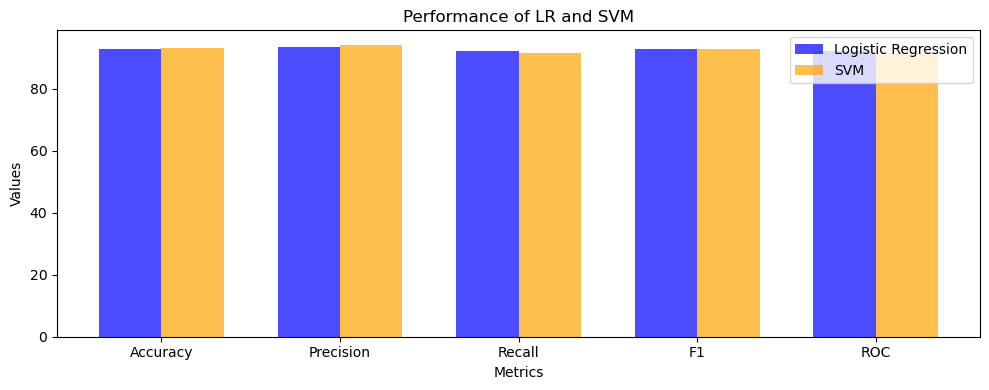

In [54]:
# Define the metrics and data for Logistic Regression and SVM
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC']
LR_data = np.array([LR_results['Accuracy'], LR_results['Precision'], LR_results['Recall'], LR_results['F1'], LR_results['Recall']])
SVM_data = np.array([SVM_results['Accuracy'], SVM_results['Precision'], SVM_results['Recall'], SVM_results['F1'], SVM_results['Recall']])

# Number of metrics
num_metrics = len(metrics)

# Set the bar width
bar_width = 0.35

# Define the positions for the bars
positions = np.arange(num_metrics)

# Plotting the graph
fig, ax = plt.subplots(figsize=(10, 4))

# Plotting bars for Logistic Regression
ax.bar(positions - bar_width/2, LR_data, width=bar_width, label='Logistic Regression', color='blue', alpha=0.7)

# Plotting bars for SVM
ax.bar(positions + bar_width/2, SVM_data, width=bar_width, label='SVM', color='orange', alpha=0.7)

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Performance of LR and SVM')
ax.set_xticks(positions)
ax.set_xticklabels(metrics)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Visualizing the perfomance using a confusion matrix

#### Models using TF-IDF Confusion Matrix

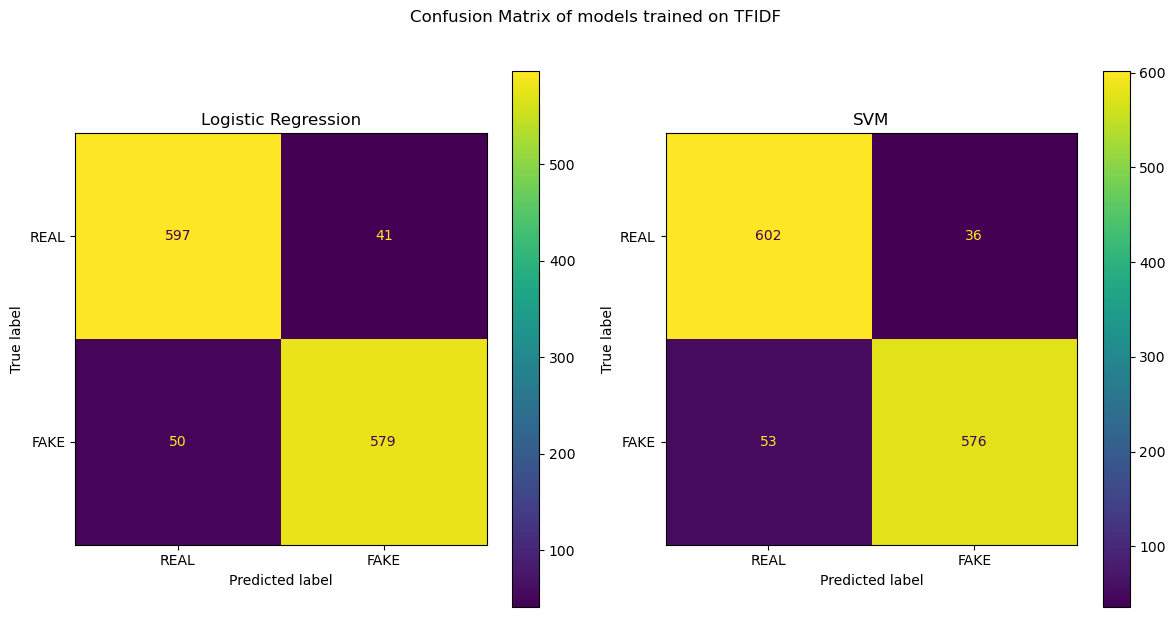

In [59]:
# Plotting subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create the confusion matrix displays for each model
LR_display = ConfusionMatrixDisplay(LR_results['CM'], display_labels=['REAL', 'FAKE'])
SVM_display = ConfusionMatrixDisplay(SVM_results['CM'], display_labels=['REAL', 'FAKE'])

# Plot the Confusion Matrices for Logistic Regression
LR_display.plot(ax=axes[0])
axes[0].set_title('Logistic Regression')

# Plot the Confusion Matrices for SVM
SVM_display.plot(ax=axes[1])
axes[1].set_title('SVM')

# Adjust layout
plt.suptitle('Confusion Matrix of models trained on TFIDF', x=0.5, y=1.02)
plt.tight_layout()
plt.show()

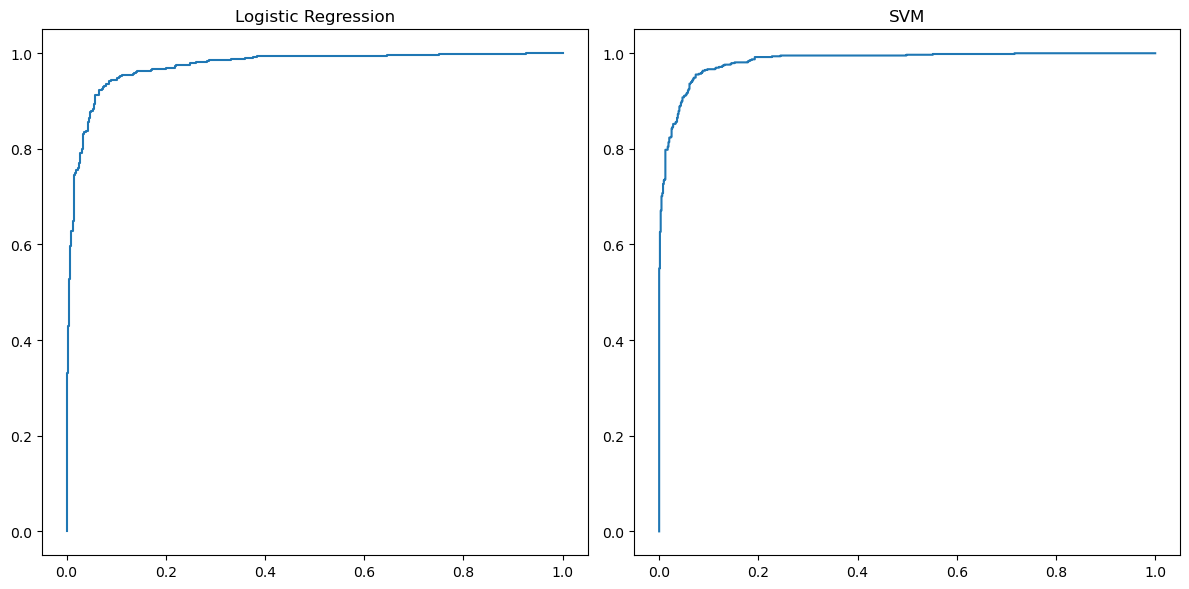

In [64]:
# Plotting subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create the ROC curve plots for Logistic Regression
axes[0].set_title('Logistic Regression')
axes[0].plot(LR_results['Curve'][0], LR_results['Curve'][1], label=f'ROC curve (AUC = {LR_results["ROC"]:.2f})')

# Create the ROC curve plots for SVM
axes[1].set_title('SVM')
axes[1].plot(SVM_results['Curve'][0], SVM_results['Curve'][1], label=f'ROC curve (AUC = {SVM_results["ROC"]:.2f})')

# Adjust layout
plt.tight_layout()
plt.show()

## Saving and loading the trained models

In [71]:
# Saving our model locally with pkl(pickle) extension
LR_filename = 'LR.pkl'
pickle.dump(LR, open(LR_filename, 'wb'))
SVM_filename = 'SVM.pkl'
pickle.dump(SVM, open(SVM_filename, 'wb'))

In [33]:
# load the model from disk
LR = pickle.load(open('LR.pkl', 'rb'))
SVM = pickle.load(open('SVM.pkl', 'rb'))

# Test our local model

# Split the dataset
LR_x_train, LR_x_test, LR_y_train, LR_y_test = featureExtract_Ngram(clean_df, n=2)
SVM_x_train, SVM_x_test, SVM_y_train, SVM_y_test = featureExtract_TFIDF(clean_df)

# Verify the accuracy of each model
# LR should be getting 92.82% and SVM should be getting 92.98%
LR_result = LR.score(LR_x_test, LR_y_test)
SVM_result = SVM.score(SVM_x_test, SVM_y_test)

print("LR: " + str(round(LR_result*100,2)) + "%")
print("SVM: " + str(round(SVM_result*100,2)) + "%")

LR: 92.82%
SVM: 92.98%


Great now that we have a trained model ready to classify fake and real news.

# Conclusion

The objective of this prototype is to identify the best parameters for feature extraction methods and models to improve the performance of Logistic Regression and SVM.

To identify the best N values for N-Gram, I have trained the logistic regression models on varying N values from 2 to 5 and the model achieved the highest accuracy of 92.5% when N value is 2 on the clean dataset. 

The Logistic Regression model is fine tuned by finding the best max_iter values and hyper parameters. I experimented max_iter values from 200 to 5000 but see no impact in the performance of the model. Next the hyper parameters are identified using GridSearch with a parameter grid of C: [0.001, 0.01, 0.1, 1, 10, 100], penalty: ['l1', 'l2'], solver: ['lbfgs', 'liblinear'] and the best parameters is 'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'.

With N-Gram where N=2 and using the best parameters the model was able to achieve an accuracy of 92.82% which is a 0.32% improvement from the default settings.
However, with the best parameters for TfidfVectorizer and SVM, the SVM model achieved 92.66% which saw a fall of 0.22%.

I believe the small gains in performance for Logistic Regression is due to the fact that we have a small amount of dataset, GridSearch may have been able to identify better parameters for the Logistic Regression model if coupled with a richer and robust dataset. However for N-Gram features the results are consistent with our literature review on [40] where models perform best when N is around 2 to 4 and falls off after.

For SVM, I believe the parameters GridSearch has identified has overfitted the model as such we see a fall in accuracy hence I have reverted SVM to use back the default settings.

With that we were able to achieve highest accuracy of 92.98% using SVM which is an improvement from [43] which uses the same dataset further proving the model.


## Reflection

Recall that in feature prototype 2 we concluded that we will be using RandomForest with word2vec feature however during fine tuning process I learnt the gridsearch is taking forever (1hour of run time but yet to complete) to load and have decided to remove RandomForest and Word2Vec feature entirely with additional consideration to the fact that it has the lowest starting score as well as a word2vec model that is trained on small dataset which in all probably would not be the most accurate compared to SVM on TFIDF which already has a promising score of 92.98% right off the bat.